In [1]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# Get data for points of interest (POIs) to estimate attraction for each zone

There are two ways of fetching data from OpenStreetmap:
* Using overpass queries
* Using locally saved osm.pbf file

Overpass queries take a long time, but work without any further packages. The faster version requires downloading a pbf file for the region of Germany. This is available here (should be saved under `input_static`: https://download.geofabrik.de/europe.html

In [2]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
import numpy as np
from quetzal.model import stepmodel
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from pyrosm import OSM, get_data
from shapely.geometry import Point, Polygon, LineString


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [3]:
# import helper functions
%run -i helperFunctions.py

In [4]:
model_path = '../model/'
input_path = '../input/'
output_path = '../outputs/'

In [5]:
show_plots = manual

## Load stepmodel

The object that contains previous work (i.e. the zones)

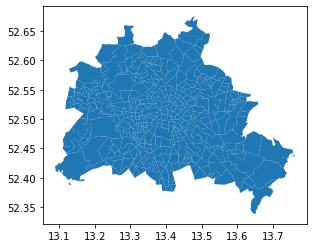

In [6]:
sm = stepmodel.read_json(model_path + 'zones')
if not type(sm.zones) == GeoDataFrame:
    sm.zones = GeoDataFrame(sm.zones, crs=sm.epsg)
if show_plots: sm.zones.plot()

# Number of POIs from OSM data

The extraction from OpenStreetmap makes use of Overpass querys (for documentation see http://osmlab.github.io/learnoverpass/en/docs/). <br>
For trying out querys and their results, use https://overpass-turbo.eu/ (although a success in overpass turbo does not always imply a success in my request). 

For documentation of OpenStreetMap data, see OSM Wiki: https://wiki.openstreetmap.org/.

In [7]:
# Load POI code Excel
poi_codes = pd.read_excel(input_path + 'zone_stats/OSM_POI_list.xlsx')
poiKeyVals = poi_codes.loc[(poi_codes['key'].notna()), ['key', 'value']].values
print(poiKeyVals[0:4])
poi_codes.loc[(poi_codes['key'].notna())&(poi_codes['value'].isna()), 'key']

[['amenity' 'college']
 ['amenity' 'school']
 ['amenity' 'university']
 ['building' 'school']]


7    craft
Name: key, dtype: object

## set up new OSM to avoid erorrs when trying to extract POIs

In [8]:
fpb = get_data("Berlin", update=True)
osmb = OSM(fpb)

Downloaded Protobuf data 'Berlin.osm.pbf' (100.39 MB) to:
'C:\Users\MARLIN~1.ARN\AppData\Local\Temp\pyrosm\Berlin.osm.pbf'


In [9]:
poiKeys = list(filter(lambda x: x == x, poi_codes['key'].unique()))
poiVals = list(filter(lambda x: x == x, poi_codes['value'].unique()))

### extract POIS from OSM

In [10]:
# prepare a list to store dataframes for each query 
pois_arr = []
# get pois data for each key
for key in poiKeys:
    # get all search values for key
    valuesForKey = list(filter(lambda x: x[0] == key, poiKeyVals))
    # if value is NaN, put True (which is the case for key="craft") instead of NaN
    valuesForKey = list(map(lambda x: x[1] if x[1]==x[1] else True, valuesForKey))
    # custom_filter will get all pois with the key and one of the values in valuesForKey
    custom_filter = {key: valuesForKey}
    print(key)
    # get_pois from OSM
    poisForKey = osmb.get_pois(custom_filter=custom_filter)
    # rename column to store value
    poisForKey.index = poisForKey['id']
    poisForKey.rename(columns = { key: 'value' }, inplace = True)
    # create column named key and store the key to
    poisForKey['key'] = key
    # only keep necessary columns
    if not 'value' in poisForKey:
        print("for ", key, "values are", valuesForKey, "values column was missing. Colnames: ", list(poisForKey))
        poisForKey['value'] = valuesForKey[0]
    # add capacity if given, else later use estimate
    if not 'capacity' in poisForKey:
        poisForKey['capacity'] = None

    poisForKey = poisForKey[['key', 'value', 'capacity', 'geometry']]
    # append to df for all keys
    pois_arr.append(poisForKey)

# merge pois to one dataframe
pois = pd.concat(pois_arr)
# set crs code correctly
pois = pois.to_crs(epsg = sm.epsg)

amenity
building
craft
shop
leisure
tourism
water
for  water values are ['lake'] values column was missing. Colnames:  ['name', 'ref', 'website', 'id', 'timestamp', 'version', 'tags', 'osm_type', 'geometry', 'changeset', 'key']


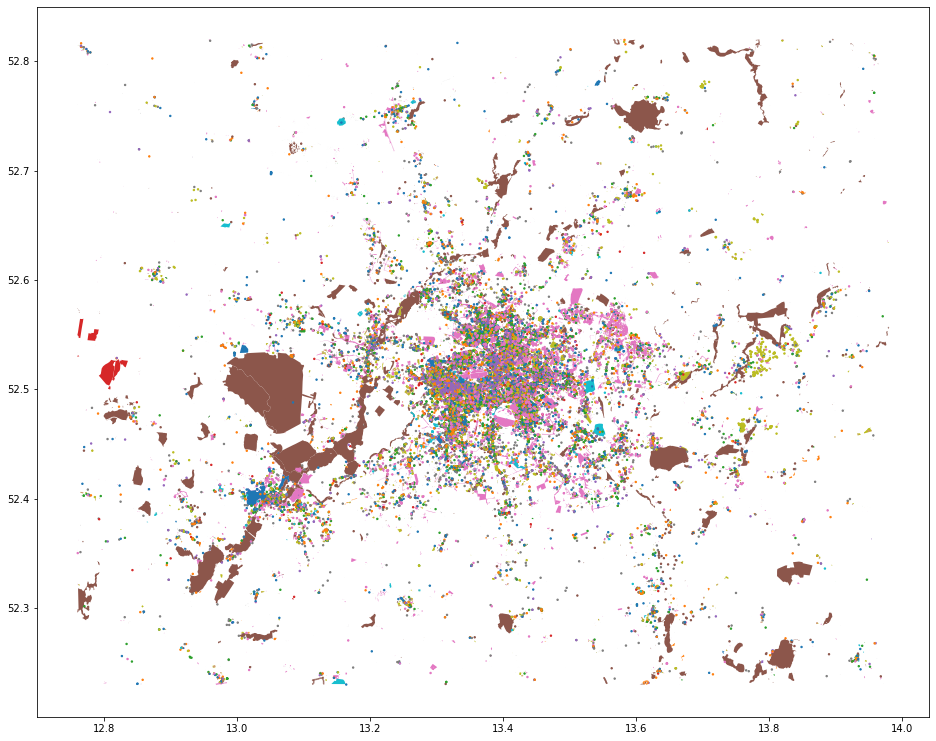

In [11]:
if show_plots: pois.plot(column = "value", markersize = 2, figsize=(16,16))

# match POI information to zones
- prepare zones dataframe to store information about POIs
- then loop through POIs, check in which zone(s) POI lies and 
- add increase the numbers of POIs in that category in that zone by 1

poiCentroid (13.29561125963987, 52.513678423126535) not within polygon for zone 04030417 ['Schloßstraße']
poiCentroid (13.179344470346555, 52.48083065623795) not within polygon for zone 05040934 ['Alt-Gatow']
poiCentroid (13.45258059130702, 52.47765557349468) not within polygon for zone 08010407 ['Gewerbegebiet Ederstraße']
poiCentroid (13.227535329270523, 52.57850097580495) not within polygon for zone 12224229 ['Konradshöhe/Tegelort']
poiCentroid (13.356219617065305, 52.59429714737688) not within polygon for zone 12302110 ['Dannenwalder Weg']


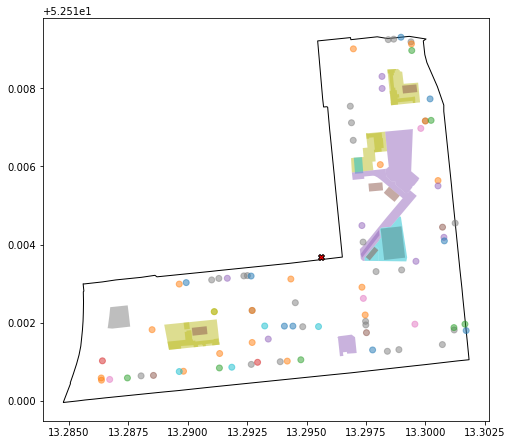

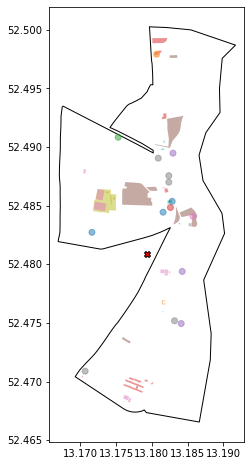

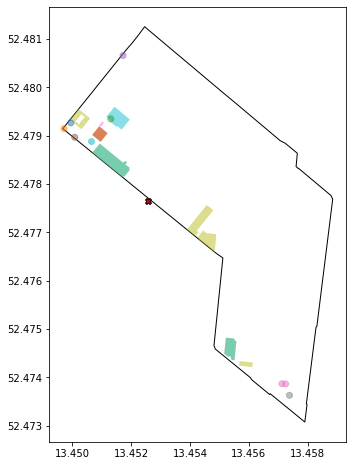

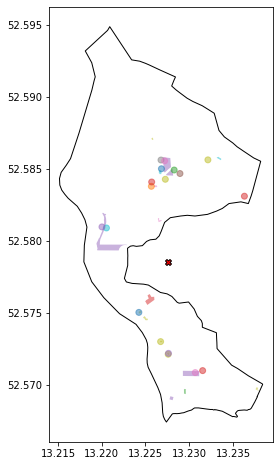

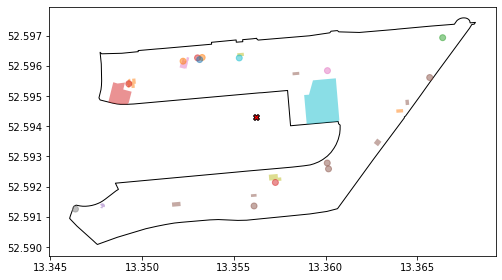

In [12]:
# create copy to not add too many columns to sm.zones
sm_zones_drop = sm.zones.copy()
# assign each amenties to one (Points) or (potentially) multiple zones (Polygons)
# this takes a very long time (about 15:00 mins)
t0 = time.time()
# add columns to geodataframe sm.zones to store ammount of amenities
#   - keys
#   - values
sm.zones["pois"] = 0
sm.zones["poiCentroid"] = Point(0,0)
sm.zones["poiCentroidOffset"] = LineString([Point(0,0), Point(0,0)])
sm.zones["poiCentroidLat"] = 0.0
sm.zones["poiCentroidLon"] = 0.0
for keyOrValue in (poiKeys + poiVals):
    sm.zones[keyOrValue] = 0

# assign zone to each building
pois['zone'] = \
    pois['geometry']\
        .apply(lambda g: sm.zones.index[sm.zones.intersects(g.centroid)])\
        .apply(lambda zi: zi)

# for each zone assign all POIs
for i in range(len(sm.zones)):
    zone = sm.zones.iloc[i]
    zoneIndex = zone.name

    poisInZone = pois[[zoneIndex in x for x in pois["zone"]]]
    
    # To-Do: imporbe centroid weighting
    
    # obtain total zone population and save to sm.zones
    zonePois = len(poisInZone)
    sm.zones.at[zoneIndex, "pois"] = zonePois
    
    # for key in poiKeys:
    #     sm.zones.at[zoneIndex, key] = len(poisInZone[poisInZone['key'] == key])
    # for value in poiVals:
    #     sm.zones.at[zoneIndex, value] = len(poisInZone[poisInZone['value'] == value])
    for key in pois['key'].unique():
        sm_zones_drop.at[zoneIndex, key] = len(poisInZone[poisInZone['key'] == key])
    for value in pois['value'].unique():
        sm_zones_drop.at[zoneIndex, value] = len(poisInZone[poisInZone['value'] == value])

    # create weighted centroids based on where most people live within 
    weigthedCoords = {"lat": 0, "lon": 0}
    for buildingIndex, building in poisInZone.iterrows():
        weigthedCoords["lon"] += 1 / zonePois * building["geometry"].centroid.x
        weigthedCoords["lat"] += 1 / zonePois * building["geometry"].centroid.y
    
    sm.zones.at[zoneIndex, "poiCentroidLat"] = weigthedCoords["lat"]
    sm.zones.at[zoneIndex, "poiCentroidLon"] = weigthedCoords["lon"]
    poiCentroid = Point(weigthedCoords["lon"], weigthedCoords["lat"])
    
    # check whether those centroids which are not within zone are still plausible
    if(not poiCentroid.intersects(zone["geometry"])):
        print("poiCentroid", poiCentroid.coords[0], "not within polygon", "for zone",
              zoneIndex, list(zone[[x for x in ['PLANUNGSRA', "nam"] if x in zone.keys()]]))
        fig, ax = plt.subplots(1, 1, figsize=(8,8))
        sm.zones.iloc[i:i+1].plot(ax=ax, color='None', edgecolor="black")
        poisInZone.plot(ax=ax, column = "value", alpha=0.5)
        GeoSeries([poiCentroid], crs=sm.epsg).plot(ax=ax, color="red", edgecolor="black", marker="X")
    
    sm.zones.loc[zoneIndex, "poiCentroid"] = poiCentroid
    # add a line between actual centroid and poi centroid
    sm.zones.loc[zoneIndex, "poiCentroidOffset"] = LineString([zone["geometry"].centroid, poiCentroid])
    # helpers.printProgress(i=zoneIndex, imax=len(sm.zones), t=time.time(), t0=t0)

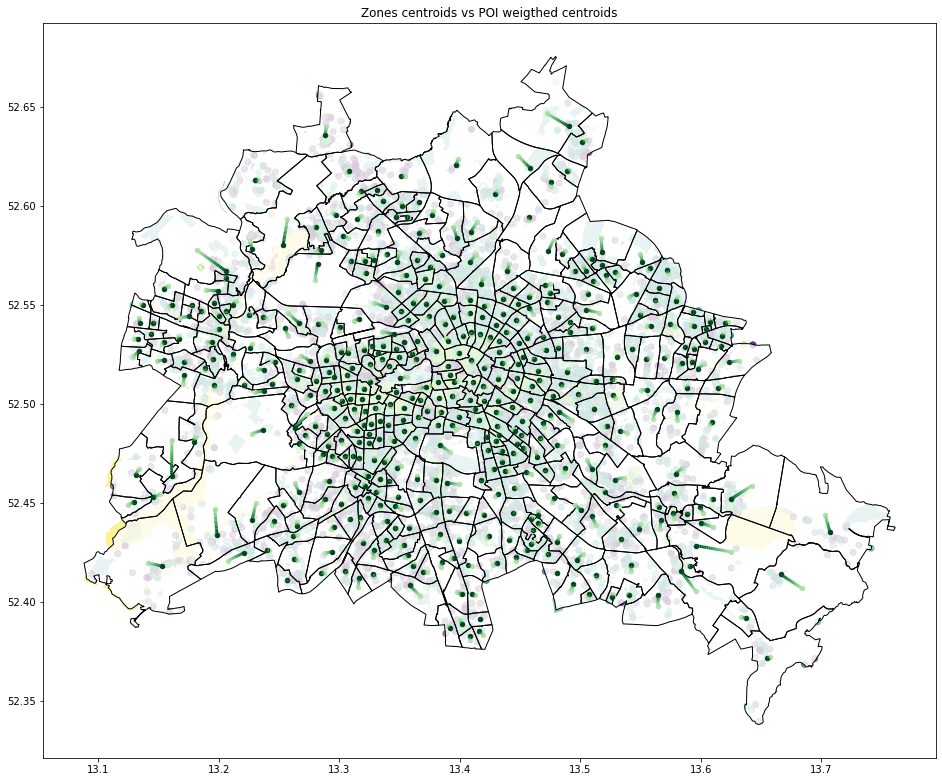

In [13]:
if show_plots:
    # show zones and popCentroids and their offsets from real geometrical centroids
    fig, ax = plt.subplots(1, 1, figsize=(16,16))

    pois[[len(z)>0 for z in pois['zone']]].plot(ax=ax, column='key', cmap = "viridis", alpha=0.5)

    # add zone borders and a bit of opacity
    sm.zones.plot(ax=ax, color = "#ffffff", alpha=0.8)
    sm.zones.plot(ax=ax, color="None", edgecolor="black", linewidth=1)
    nSteps = 20
    cbuff = 10
    cmap = plt.get_cmap('Greens_r', nSteps + cbuff)
    gpd.GeoSeries(sm.zones.geometry.centroid, crs=sm.epsg).plot(ax=ax, color = cmap(nSteps), markersize = 20)
    for i in range(1,nSteps):
        l = [helpers.segmentLine(x, i, nSteps) for x in sm.zones.poiCentroidOffset]
        gpd.GeoSeries(l, crs=sm.epsg).plot(ax=ax,color=cmap(i), linewidth=3)
    gpd.GeoSeries(sm.zones.poiCentroid, crs=sm.epsg).plot(ax=ax, color = cmap(0), markersize = 20)
    ax.set_title("Zones centroids vs POI weigthed centroids")
    plt.savefig(output_path+'plots/centroids_POI_vs_pop'+'_dpi300.png', dpi=300)
    plt.savefig(output_path+'plots/centroids_POI_vs_pop'+'_dpi600.png', dpi=600)

## inspect POIs per zone

### For POI keys

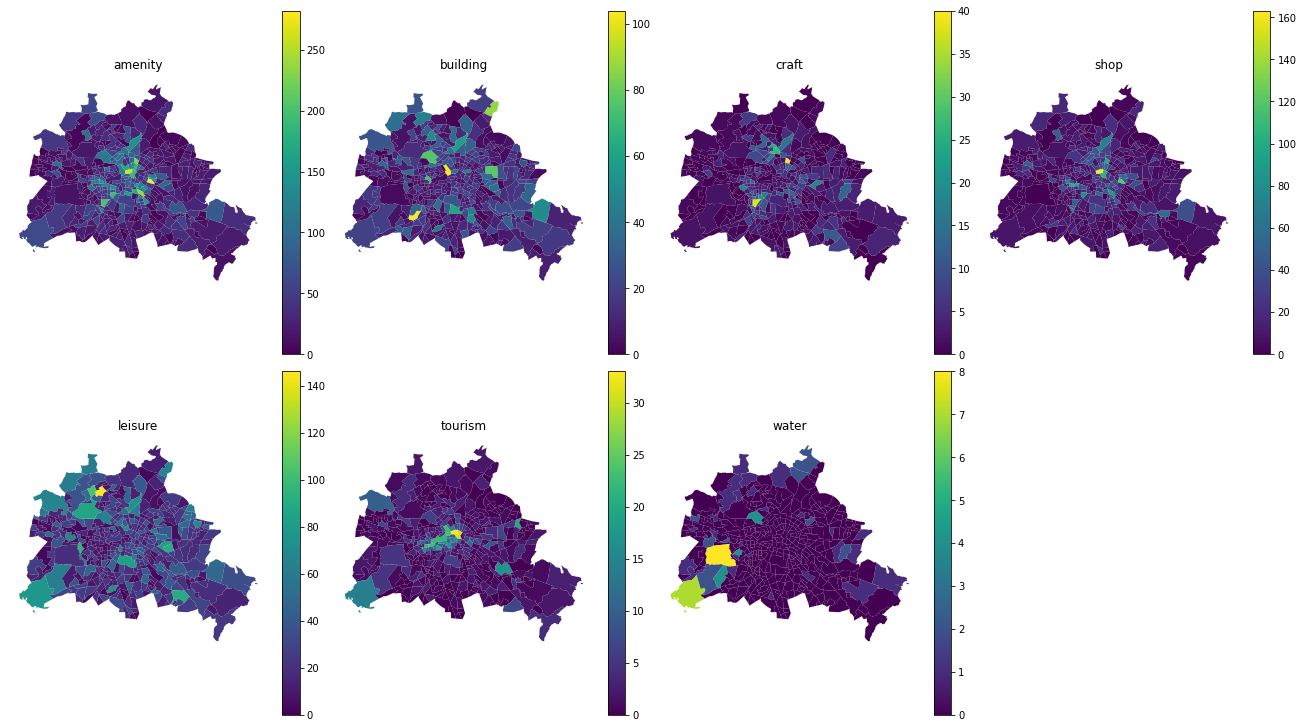

In [14]:
if show_plots:
    t0=time.time()
    # Show maps for keys
    clmns = pois['key'].unique()
    ncols = 4
    def ceil (n):
        return(n // 1 + 1 if(n - n // 1) else n)
    nrows = int(ceil(len(clmns) / ncols))

    fig, axs = plt.subplots(nrows, ncols, figsize=(18,5*nrows), sharex='all', sharey='all', constrained_layout=True)
    col_num = 0
    for ind, clmn in enumerate(clmns):
        sm_zones_drop.plot(column=clmn, ax=axs.flat[ind], legend=True)
        axs.flat[ind].set_axis_off()
        axs.flat[ind].set_title(clmn)
        # helpers["printProgress"](i=ind, imax=len(clmns), t=time.time(), t0=t0)

    ## remove empty plots
    for ax in axs.flat:
        ## check if something was plotted 
        if not bool(ax.has_data()):
            fig.delaxes(ax) ## delete if nothing is plotted in the axes obj
    plt.savefig(output_path+'plots/POI_count_by_key'+'_dpi300.png', dpi=300)
    plt.savefig(output_path+'plots/POI_count_by_key'+'_dpi600.png', dpi=600)

### For POI values

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%. Minutes elapsed: 06:44. Minutes remaining: 00:00. 

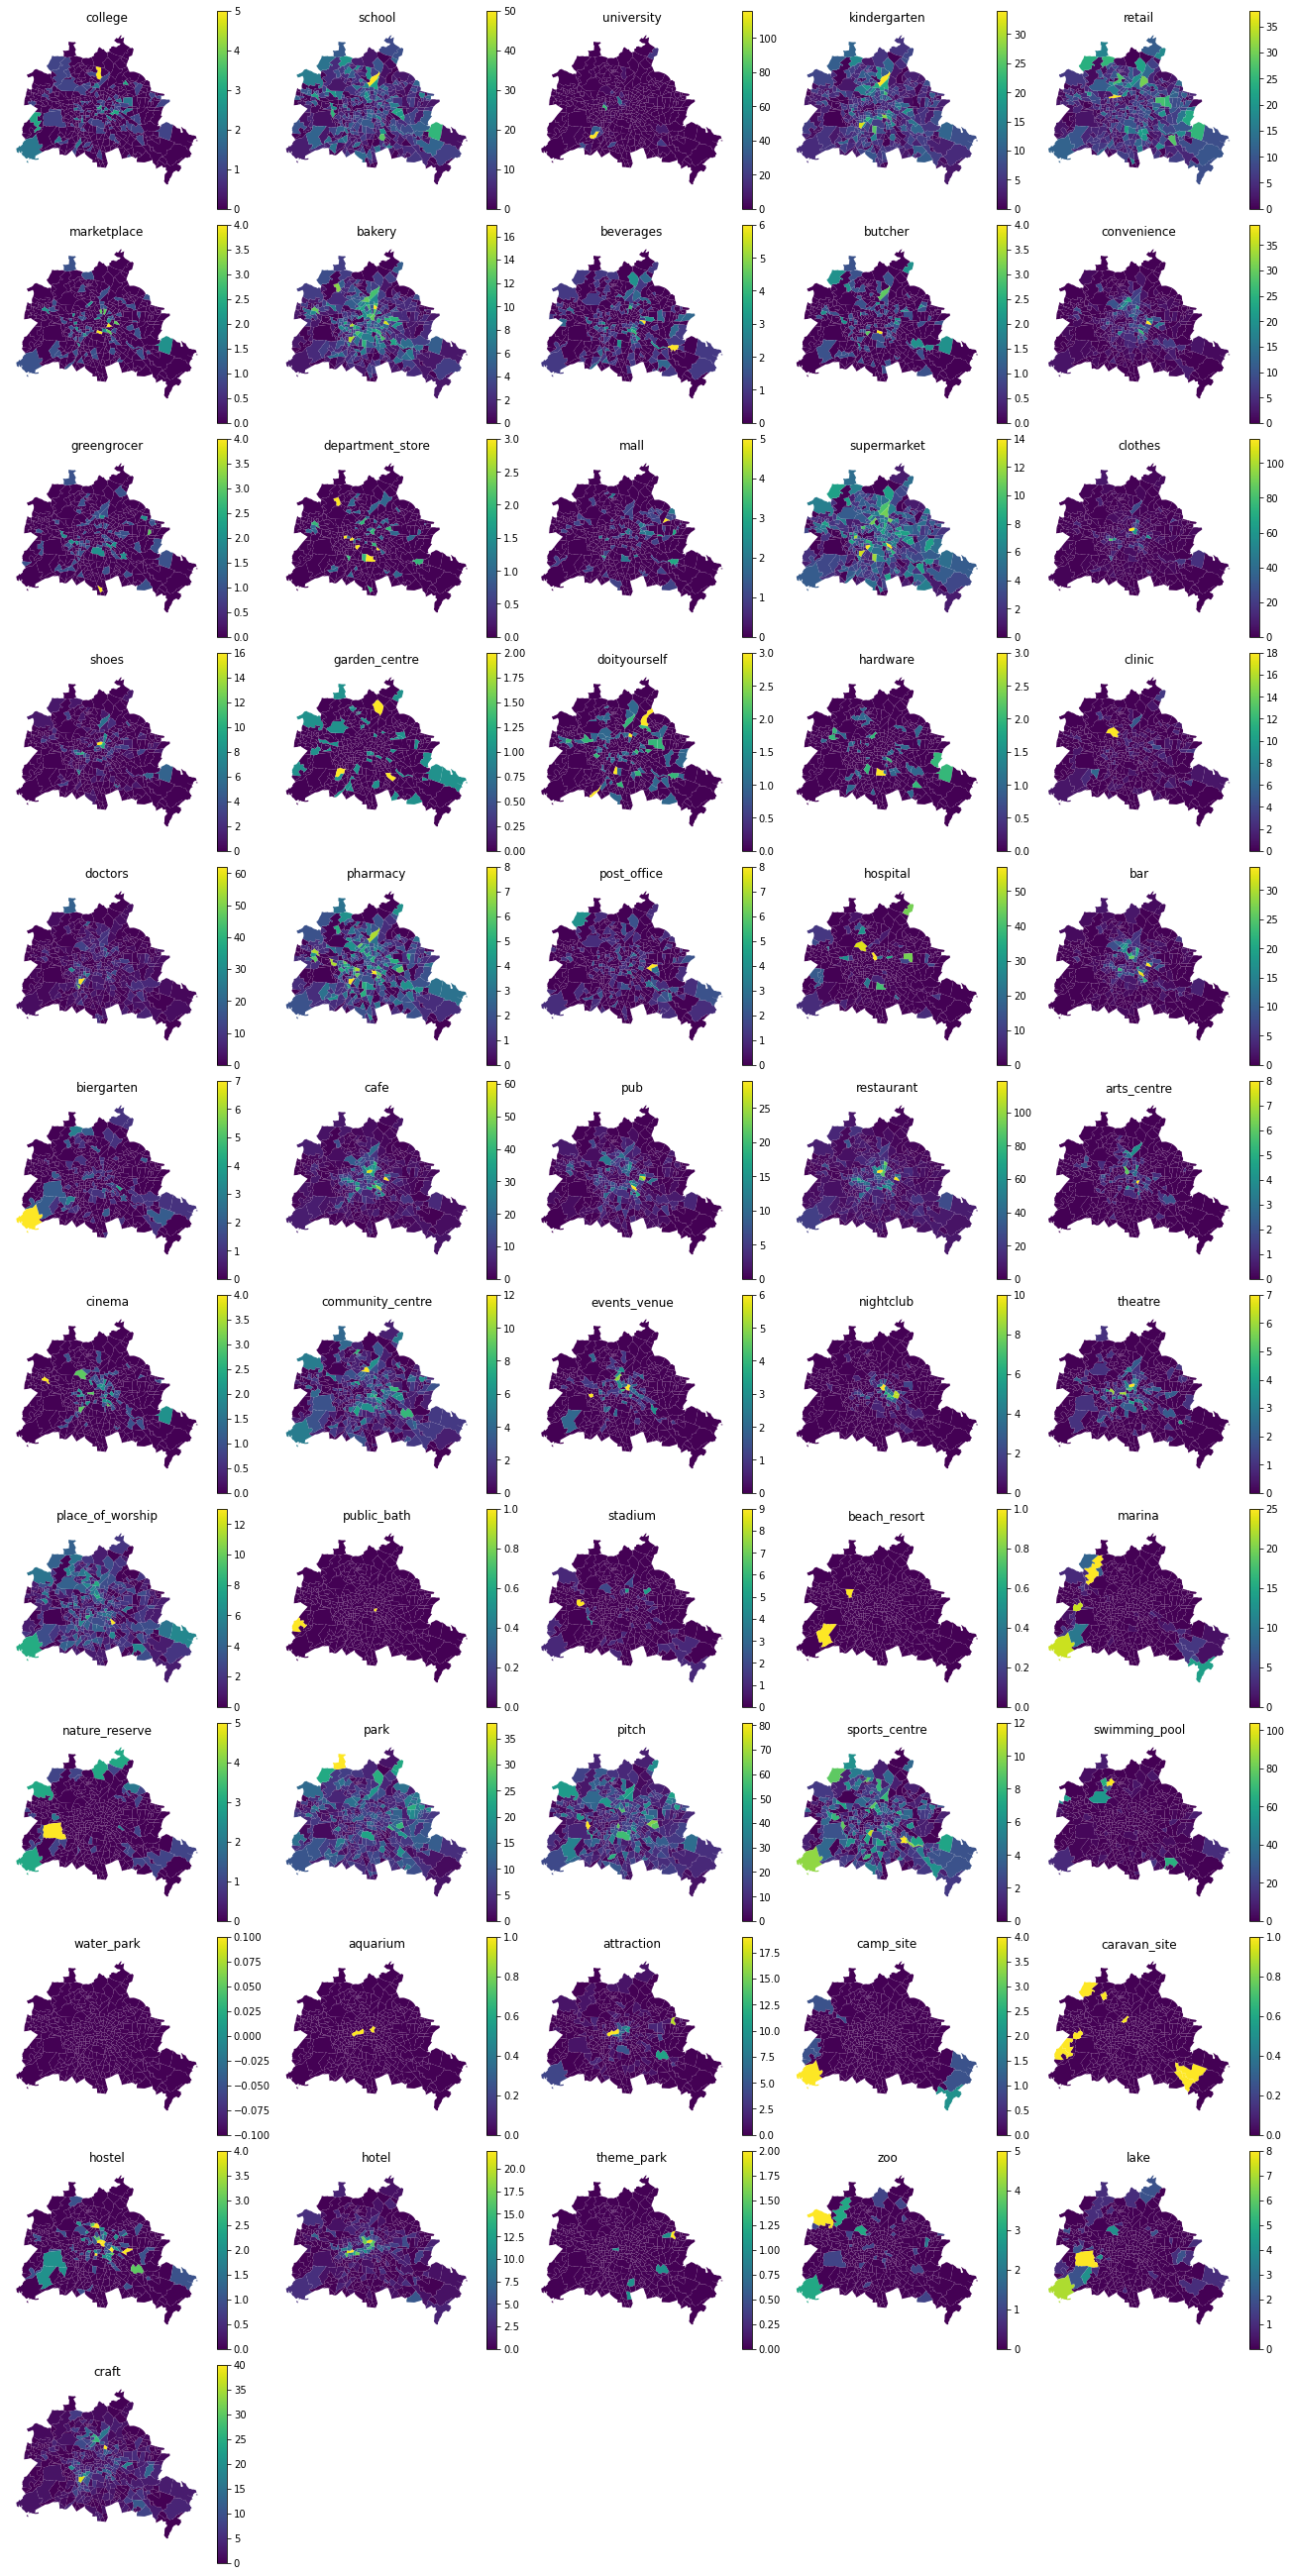

In [15]:
if show_plots:
    t0=time.time()
    # Show maps for values # takes roughly 5 Minutes
    clmns = poiVals + ["craft"]
    ncols = 5
    def ceil (n):
        return(n // 1 + 1 if(n - n // 1) else n)

    nrows = int(ceil(len(clmns) / ncols))

    fig, axs = plt.subplots(nrows, ncols, figsize=(18, 3*nrows), sharex='all', sharey='all', constrained_layout=True)
    col_num = 0
    for ind, clmn in enumerate(clmns):
        sm_zones_drop.plot(column=clmn, ax=axs.flat[ind], legend=True)
        axs.flat[ind].set_axis_off()
        axs.flat[ind].set_title(clmn)
        helpers.printProgress(i=ind, imax=len(clmns), t=time.time(), t0=t0)

    ## remove empty plots
    for ax in axs.flat:
        ## check if something was plotted 
        if not bool(ax.has_data()):
            fig.delaxes(ax) ## delete if nothing is plotted in the axes obj
    
    
    plt.savefig(output_path+'plots/POI_count_by_value'+'_dpi300.png', dpi=300)
    plt.savefig(output_path+'plots/POI_count_by_value'+'_dpi600.png', dpi=600)

## Categorize point of interests into trip purposes

In [16]:
wege_zweck_poiskeys = pd.read_excel(input_path + 'transport_stats/wege_zweck_poiskeys.xlsx')
wege_zweck_poiskeys

Ziel/Zweck  Binnenverkehr  \
0                                           Education            6.6   
1                                            Shopping           11.4   
2                                       Own workplace           13.1   
3                           Other place of work/route            2.1   
4                        Visit to authorities, doctor            3.2   
5   Service facility (e.g. post office. bank. hair...            2.5   
6                            Culture, theater, cinema            0.7   
7                                 Restaurant/pub/cafe            3.1   
8                                  Recreation, Sports            8.7   
9                                       Own apartment           39.2   
10                                        Other Total            9.2   
11                              Ungewichtete Fallzahl       123899.0   
12                                Gewichtete Fallzahl       124418.0   

    QuellundZielverkehr  AlleWege                 Wegzweck  km_Wegzweck  \
0                   3.0       6.3  Education;Accompaniment          7.5   
1                   6.6      11.2                 Shopping          5.0   
2                  18.3      13.4                     Work         12.0   
3                   6.9       2.5                     Work         18.0   
4                   1.4       3.1                  Errands         10.0   
5                   1.1       2.4                  Errands         10.0   
6                   0.3       0.7                  Leisure         15.0   
7                   1.5       3.2                  Leisure         15.0   
8                   9.7       8.9                  Leisure         15.0   
9                  39.4      38.9                  Leisure         15.0   
10                 11.8       9.4                      NaN          NaN   
11               6179.0  131214.0                      NaN          NaN   
12               6309.0  131910.0                      NaN          NaN   

                                             POI-keys  \
0              kindergarten;school;university;college   
1   pharmacy;marketplace;retail;hardware;garden_ce...   
2                                                 NaN   
3                                                 NaN   
4                             doctors;clinic;hospital   
5   roofer;electronics_repair;beekeeper;joiner;pri...   
6   cinema;arts_centre;theatre;nightclub;events_venue   
7   restaurant;biergarten;cafe;pub;bar;icecream;ho...   
8   community_centre;public_bath;stadium;beach_res...   
9                                                 NaN   
10                                                NaN   
11                                                NaN   
12                                                NaN   

                                   Ziel/Zweck deutsch       Wegzweck deutsch  
0                                        Summe Schule  Ausbildung;Begleitung  
1                                       Summe Einkauf                Einkauf  
2                                Eigener Arbeitsplatz                 Arbeit  
3                              Anderer Dienstort/-weg                 Arbeit  
4                            Behördengang. Arztbesuch             Erledigung  
5   Dienstleistungseinrichtung (z. B. Post. Bank. ...             Erledigung  
6                               Kultur. Theater. Kino               Freizeit  
7                                   Gaststätte/Kneipe               Freizeit  
8                                Summe Sport Freizeit               Freizeit  
9                                      Eigene Wohnung               Freizeit  
10                                    Sonstiges Summe                    NaN  
11                              Ungewichtete Fallzahl                    NaN  
12                                Gewichtete Fallzahl                    NaN

In [17]:
# zahlen aus survey
anz_wege_surv = wege_zweck_poiskeys['AlleWege'][wege_zweck_poiskeys['Ziel/Zweck'] == 'Ungewichtete Fallzahl'][11]
anz_befragte = 40190 

# Faktor zur hochrechnung
faktor_berlin = sm.zones['pop'].sum()/anz_befragte

zwecke = wege_zweck_poiskeys['Ziel/Zweck'].values[0:11]
key_string_for_zwecke = wege_zweck_poiskeys['POI-keys'].values[0:11]
anz_wege_surv_for_zweck = wege_zweck_poiskeys['AlleWege'].values[0:11]

In [18]:
# dictionary von osm tags zu Ziel/Zweck aus SrV servey
poi_to_zweck_dict = {}
zweck_to_poi_dict = {}
for zweck, key_string in zip(zwecke, key_string_for_zwecke):
    zweck_to_poi_dict[zweck] = []
    if(not type(key_string) == str):
        keys = []
    else:
        keys = key_string.rsplit(';')
    keys = [key for key in keys if not key == '']
    # print('keys', keys)
    for key in keys:
        if key in sm_zones_drop.columns:
            zweck_to_poi_dict[zweck].append(key)
            if key in poi_to_zweck_dict.keys():
                print(key, zweck)
                raise('poi key used for more than one zweck!', key, zweck)
            poi_to_zweck_dict[key] = zweck

#print(zweck_to_poi_dict)
#'Service facility (e.g. post office. bank. hairdresser)'

In [19]:
# absolute Zahlen Trips je Zweck
zweck_abs_dict = {}

for zweck, p_zweck in zip(zwecke, anz_wege_surv_for_zweck):
    zweck_abs_dict[zweck] = int(p_zweck/100 * anz_wege_surv * faktor_berlin)

zweck_abs_dict

{'Education': 776548,
 'Shopping': 1380529,
 'Own workplace': 1651705,
 'Other place of work/route': 308153,
 'Visit to authorities, doctor': 382110,
 'Service facility (e.g. post office. bank. hairdresser)': 295827,
 'Culture, theater, cinema': 86283,
 'Restaurant/pub/cafe': 394437,
 'Recreation, Sports': 1097028,
 'Own apartment': 4794876,
 'Other Total': 1158659}

In [20]:
pois_count_zweck = {}
for zweck in zwecke:
    pois_count_zweck[zweck] = 0
    for key in zweck_to_poi_dict[zweck]:
            pois_count_zweck[zweck] += sm_zones_drop[key].sum()

pois_count_zweck

{'Education': 6272.0,
 'Shopping': 9656.0,
 'Own workplace': 0,
 'Other place of work/route': 0,
 'Visit to authorities, doctor': 2157.0,
 'Service facility (e.g. post office. bank. hairdresser)': 1299.0,
 'Culture, theater, cinema': 683.0,
 'Restaurant/pub/cafe': 9648.0,
 'Recreation, Sports': 11672.0,
 'Own apartment': 0,
 'Other Total': 0}

In [21]:
print('attraction per poi',[(key, zweck_abs_dict[key]/pois_count_zweck[key]) for key in pois_count_zweck.keys() if pois_count_zweck[key] > 0])

attraction per poi [('Education', 123.81186224489795), ('Shopping', 142.97110604805303), ('Visit to authorities, doctor', 177.1488178025035), ('Service facility (e.g. post office. bank. hairdresser)', 227.73441108545035), ('Culture, theater, cinema', 126.3294289897511), ('Restaurant/pub/cafe', 40.8827736318408), ('Recreation, Sports', 93.98800548320767)]


In [22]:
print('', \
    round(1-sum([zweck_abs_dict[key]for key in pois_count_zweck.keys() if not pois_count_zweck[key] > 0])/sum([zweck_abs_dict[key]for key in pois_count_zweck.keys()]),3)*100,\
        'perecent of all trips are captured by POIs.'
        )

 35.8 perecent of all trips are captured by POIs.


In [23]:
sm.zones['Total POI attraction'] = 0
for zweck in zwecke:
    if pois_count_zweck[zweck] > 0:
        print(zweck)
        sm.zones[zweck] = sm_zones_drop.apply(lambda row: sum([row[key]*zweck_abs_dict[zweck]/pois_count_zweck[zweck] for key in zweck_to_poi_dict[zweck] if key in sm_zones_drop.columns]), axis=1 )
        sm.zones['Total POI attraction'] += sm.zones[zweck]

Education
Shopping
Visit to authorities, doctor
Service facility (e.g. post office. bank. hairdresser)
Culture, theater, cinema
Restaurant/pub/cafe
Recreation, Sports


|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%. Minutes elapsed: 00:05. Minutes remaining: 00:00. 

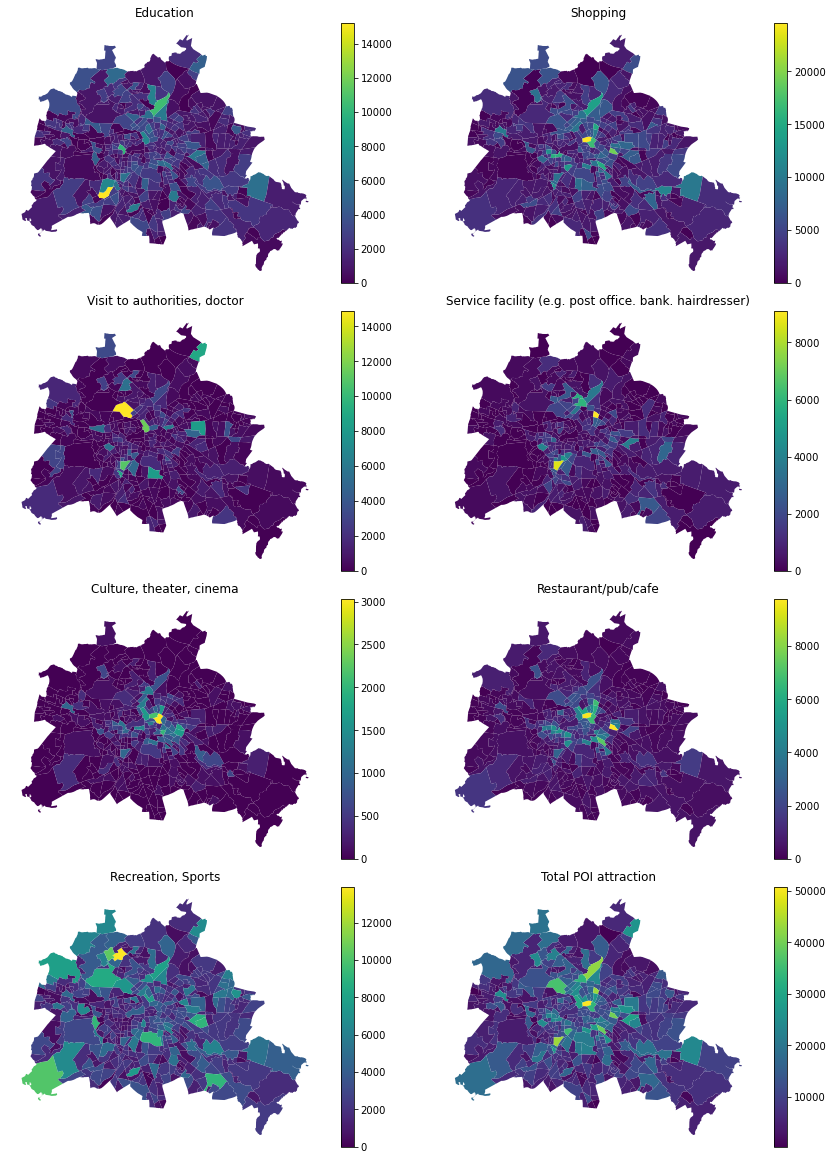

In [24]:
if show_plots:
    t0=time.time()
    # Show maps for values # takes roughly 5 Minutes
    clmns = [z for z in zwecke if z in sm.zones.columns]+['Total POI attraction']
    ncols = 2
    def ceil (n):
        return(n // 1 + 1 if(n - n // 1) else n)

    nrows = int(ceil(len(clmns) / ncols))

    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 4*nrows), sharex='all', sharey='all', constrained_layout=True)
    col_num = 0
    for ind, clmn in enumerate(clmns):
        sm.zones.plot(column=clmn, ax=axs.flat[ind], legend=True)
        axs.flat[ind].set_axis_off()
        axs.flat[ind].set_title(clmn)
        helpers.printProgress(i=ind, imax=len(clmns), t=time.time(), t0=t0)

    ## remove empty plots
    for ax in axs.flat:
        ## check if something was plotted 
        if not bool(ax.has_data()):
            fig.delaxes(ax) ## delete if nothing is plotted in the axes obj

    plt.savefig(output_path+'plots/POI_attraction_by_purpose'+'_dpi300.png', dpi=300)
    plt.savefig(output_path+'plots/POI_attraction_by_purpose'+'_dpi600.png', dpi=200)

## Save Model

In [25]:
sm.zones.columns

Index(['BEZIRKSNAM', 'PLANUNGSRA', 'FLAECHENGR', 'pop', 'popCentroidLat',
       'popCentroidLon', 'emp', 'geometry', 'pois', 'poiCentroid',
       'poiCentroidOffset', 'poiCentroidLat', 'poiCentroidLon', 'amenity',
       'building', 'craft', 'shop', 'leisure', 'tourism', 'water', 'college',
       'school', 'university', 'kindergarten', 'retail', 'marketplace',
       'bakery', 'beverages', 'butcher', 'convenience', 'greengrocer',
       'department_store', 'mall', 'supermarket', 'clothes', 'shoes',
       'garden_centre', 'doityourself', 'hardware', 'clinic', 'doctors',
       'pharmacy', 'post_office', 'hospital', 'bar', 'biergarten', 'cafe',
       'pub', 'restaurant', 'arts_centre', 'cinema', 'community_centre',
       'events_venue', 'nightclub', 'theatre', 'place_of_worship',
       'public_bath', 'stadium', 'beach_resort', 'marina', 'nature_reserve',
       'park', 'pitch', 'sports_centre', 'swimming_pool', 'water_park',
       'aquarium', 'attraction', 'camp_site', 'caravan_s

In [26]:
# Saving table
pois.to_csv(input_path + 'zone_stats/pois_raw.csv')
sm.zones.to_csv(input_path + 'zone_stats/pois_per_zone.csv')

In [28]:
# drop columns
to_drop = list(set(pois['key'])) + list(set(pois['value']))
to_drop += ['Total POI attraction', 'poiCentroid', 'poiCentroidOffset']
sm.zones.drop(columns=to_drop, errors='ignore', inplace=True)

In [29]:
sm.zones.sample()

BEZIRKSNAM       PLANUNGSRA  FLAECHENGR    pop  popCentroidLat  \
index                                                                     
05010206    Spandau  Gütersloher Weg  1765018.81  10998       52.550917   

          popCentroidLon         emp  \
index                                  
05010206       13.159825  624.402955   

                                                   geometry  pois  \
index                                                               
05010206  POLYGON ((13.14422 52.55212, 13.14458 52.55255...    66   

          poiCentroidLat  poiCentroidLon    Education     Shopping  \
index                                                                
05010206       52.549927       13.160989  2352.425383  1715.653273   

          Visit to authorities, doctor  \
index                                    
05010206                           0.0   

          Service facility (e.g. post office. bank. hairdresser)  \
index                                                              
05010206                                         227.734411        

          Culture, theater, cinema  Restaurant/pub/cafe  Recreation, Sports  
index                                                                        
05010206                       0.0           245.296642         2631.664154

In [30]:
# Saving model zones as geojson
sm.to_json(model_path + 'zones', only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 30.24it/s]
